In [14]:
import torch
from torch import nn
import datasets as ds
from pprint import pprint
from tqdm import tqdm
from torchtext.vocab import build_vocab_from_iterator
from matplotlib import pyplot as plt

# Documentation

https://pytorch.org/docs/stable/generated/torch.nn.RNNCell.html

https://pytorch.org/docs/stable/generated/torch.nn.GRU.html

https://blog.floydhub.com/gru-with-pytorch/


# Basic cell - to compare

In [15]:
class BasicRNNCell(nn.Module):
    def __init__(self, embed_dim, hidden_dim):
        super().__init__()
        self.hidden_state = torch.zeros(hidden_dim)
        self.hidden_linear= nn.Linear(in_features = hidden_dim,
                                     out_features = hidden_dim)
        self.input_linear = nn.Linear(in_features = embed_dim,
                                     out_features = hidden_dim)
        self.activation   = nn.Tanh()
    def forward(self, one_embedded_token):
        Z1        = self.input_linear(one_embedded_token)
        Z2        = self.hidden_linear(self.hidden_state)
        Y         = Z1+Z2
        new_state = self.activation(Y)
        self.hidden_state = new_state
        #return

# Modified cell

## Why I chose this activation

I chose Sigmoid activation because it allows 'forgetting' some information about the tensor / token.

One of the main reason to even have reset gate, is to forget the previous context.

For example:

'Shlomi is a good boy. Dr Idan did not like him.'

The first sentence is positive, the second is negative. The ML learning the first sentence, but then comes the second sentence. The first sentence affects the computation of the probability of positive/negative sentiment of the model. So, to fix this, we can allow reset gate to foret the previous information gathered (about 'Shlomi is a good boy.') and continue with fresh context about the second sentence.

In [16]:
class ModifiedRNNCell(nn.Module):
	def __init__(self, embed_dim, hidden_dim):
		super().__init__()
		self.hidden_state = torch.zeros(hidden_dim)
		self.hidden_state_reset = torch.zeros(hidden_dim)

		self.hidden_linear= nn.Linear(in_features = hidden_dim, out_features = hidden_dim)
		self.input_linear = nn.Linear(in_features = embed_dim, out_features = hidden_dim)

		self.reset_linear = nn.Linear(in_features = embed_dim, out_features = hidden_dim)

		self.tanh_activation   = nn.Tanh()
		self.sigmoid_activation = nn.Sigmoid()
	def forward(self, one_embedded_token):
		input        = self.input_linear(one_embedded_token)  # X_t - current input
		hidden_state = self.hidden_linear(self.hidden_state)  # H_(t-1) - previous hidden state
		H_hat = self.tanh_activation(input + hidden_state)

		# https://blog.floydhub.com/gru-with-pytorch/

		# Reset gate
		R_t = self.reset_linear(one_embedded_token)  # Depends on input at timestep t only
		new_H_t = H_hat * R_t
		self.hidden_state = self.sigmoid_activation(new_H_t)  # H_t - new hidden state. Sigmoid because output is between 0 and 1.

# Compare

In [17]:
dataset = ds.load_dataset("glue", "sst2")

sentence_list=dataset["train"]["sentence"]
labels_list=dataset["train"]["label"]
tokenize = lambda x: x.split()
tokenized=list(map(tokenize,sentence_list))

vocab=build_vocab_from_iterator(tokenized, specials=["<UNK>"],min_freq=5)
vocab.set_default_index(0)

func = lambda x: torch.tensor(vocab(x))
integer_tokens=list(map(func,tokenized))
label_tensors=list(map(torch.tensor,labels_list))

test_split=len(integer_tokens)*8//10
train_tokens=integer_tokens[:test_split]
train_labels=label_tensors[:test_split]
test_tokens=integer_tokens[test_split:]
test_labels=label_tensors[test_split:]

Reusing dataset glue (C:\Users\Shlomi\.cache\huggingface\datasets\glue\sst2\1.0.0\dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)
100%|██████████| 3/3 [00:00<00:00, 749.56it/s]


In [18]:
class BaseRNNClassifier(nn.Module):
	def __init__(self, embed_dim, hidden_dim, is_basic_rnn: True):
		super().__init__()
		self.hidden_dim = hidden_dim
		self.embedding  = nn.Embedding(len(vocab),embed_dim)

		if is_basic_rnn:
			self.rnn = BasicRNNCell(embed_dim, hidden_dim)
		else:
			self.rnn = ModifiedRNNCell(embed_dim, hidden_dim)
		
		self.linear     = nn.Linear(hidden_dim, 2)
		self.logsoftmax = nn.LogSoftmax(dim=0)

	def forward(self, sentence_tokens):
		self.rnn.hidden_state = torch.zeros(self.hidden_dim)
		for one_token in sentence_tokens:
			one_embedded_token = self.embedding(one_token)
			self.rnn(one_embedded_token)

		feature_extractor_output = self.rnn.hidden_state
		class_scores       = self.linear(feature_extractor_output)
		logprobs           = self.logsoftmax(class_scores)
		return logprobs

class BasicRNNClassifier(BaseRNNClassifier):
	def __init__(self, embed_dim, hidden_dim):
		super().__init__(embed_dim, hidden_dim, is_basic_rnn=True)

class ModifiedRNNClassifier(BaseRNNClassifier):
	def __init__(self, embed_dim, hidden_dim):
		super().__init__(embed_dim, hidden_dim, is_basic_rnn=False)

def iterate_one_sentence(model, optimizer, tokens,label,train_flag):
	if train_flag:
		model.train()  
		optimizer.zero_grad()
		y_model=model(tokens)
		loss= -y_model[label] #Cross Entropy
		loss.backward()
		optimizer.step()
	else:
		model.eval()
		y_model=model(tokens)
		model.train()
	with torch.no_grad():
		predicted_labels = y_model.argmax()
		success = (predicted_labels == label)
	return success

In [19]:
BATCH_SIZE, EPOCHES = 200, 50

In [20]:
def train_model(model, optimizer):
	epoch_acc = []

	parameters = list(model.parameters())
	avg_grad_norms=torch.zeros(EPOCHES)
	for epoch in tqdm(range(EPOCHES)):
		correct_predictions=torch.tensor([0.])
		grad_norm_temp=torch.zeros(BATCH_SIZE)
		for idx in range(BATCH_SIZE):
			sentence = sentence_list[idx]
			correct_predictions += iterate_one_sentence(model, optimizer, train_tokens[idx],train_labels[idx],train_flag=True)
			norms = [p.grad.detach().abs().max() for p in parameters if p.grad is not None]
			grad_norm_temp[idx] = torch.max(torch.stack(norms))
		avg_grad_norms[epoch] = grad_norm_temp.mean()
		
		acc=correct_predictions/BATCH_SIZE
		epoch_acc.append(acc)
		# if epoch%3==0:
		# 	print("Epoch",epoch," acc:",acc.item())
	return epoch_acc, grad_norm_temp

In [21]:
basic_model=BasicRNNClassifier(10,10)
basic_model_optimizer = torch.optim.AdamW(basic_model.parameters())

modified_model = ModifiedRNNClassifier(10,10)
modified_model_optimizer = torch.optim.AdamW(modified_model.parameters())

In [22]:
basic_acc, basic_grad_norm_temp = train_model(basic_model, basic_model_optimizer)
modified_acc, modified_grad_norm_temp = train_model(modified_model, modified_model_optimizer)

100%|██████████| 20/20 [00:26<00:00,  1.31s/it]


# Train accuracy

c:\Users\Shlomi\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
c:\Users\Shlomi\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


Text(0.5, 1.0, 'Train accuracy')

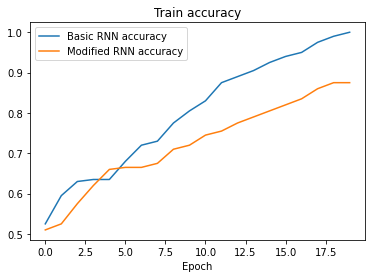

In [23]:
plt.plot(basic_acc, label="Basic RNN accuracy")
plt.plot(modified_acc, label="Modified RNN accuracy")
plt.legend()
plt.xlabel("Epoch")
plt.title("Train accuracy")

# Average Inf Norm

We can see that our modified cell deals with explodnig gradients!

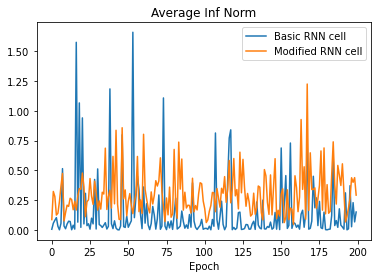

In [24]:
plt.plot(basic_grad_norm_temp, label="Basic RNN cell")
plt.plot(modified_grad_norm_temp, label="Modified RNN cell")
plt.legend()
plt.xlabel("Epoch")
plt.title("Average Inf Norm");

# Test accuracy

In [25]:
# Basic RNN cell
basic_test_correct_predictions=torch.tensor([0.])
for tokens,label in tqdm(zip(test_tokens,test_labels),total=len(test_tokens)):
	basic_test_correct_predictions += iterate_one_sentence(basic_model, basic_model_optimizer, tokens,label,train_flag=False)
basic_test_acc=basic_test_correct_predictions/len(test_tokens)

# Modified RNN cell
modified_test_correct_predictions=torch.tensor([0.])
for tokens,label in tqdm(zip(test_tokens,test_labels),total=len(test_tokens)):
	modified_test_correct_predictions += iterate_one_sentence(modified_model, modified_model_optimizer, tokens,label,train_flag=False)
modified_test_acc=modified_test_correct_predictions/len(test_tokens)

100%|██████████| 13470/13470 [00:18<00:00, 724.81it/s]


In [26]:
basic_test_acc, modified_test_acc

(tensor([0.5081]), tensor([0.5076]))